In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
from sklearn.metrics import r2_score, mean_absolute_percentage_error

In [2]:
data = pd.read_csv("D:\\4TH YEAR\\FYP\\taasha\\randsam_BABY.csv")

In [3]:
input_features = ['Timestamp', 'volData', 'currentData']
output_features = ['batTempData', 'socData', 'sohData', 'motTempData', 'speedData']

In [4]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X = scaler_x.fit_transform(data[input_features])
y = scaler_y.fit_transform(data[output_features])


In [5]:
n = 5
X_downsampled = X[::n, :]
y_downsampled = y[::n, :]

In [6]:
def create_sequences(X, y, input_timesteps, output_timesteps):
    X_seq, y_seq = [], []
    for i in range(max(input_timesteps, output_timesteps), len(X)):
        X_seq.append(X[i-input_timesteps:i, :])
        y_seq.append(y[i-output_timesteps:i, :])
    return np.array(X_seq), np.array(y_seq)

input_timesteps = 60
output_timesteps = 30
X_lstm, y_lstm = create_sequences(X_downsampled, y_downsampled, input_timesteps, output_timesteps)

In [7]:
train_size = int(len(X_lstm) * 0.8)
X_train, X_test = X_lstm[:train_size], X_lstm[train_size:]
y_train, y_test = y_lstm[:train_size], y_lstm[train_size:]

In [8]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(input_timesteps, X_lstm.shape[2]),kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    Dropout(0.3),
    LSTM(64, return_sequences=True,kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    Dropout(0.3),
    LSTM(32,kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    Dense(64, activation='relu',kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    Dense(len(output_features))
])

c:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [10]:
checkpoint = ModelCheckpoint('LSTM_model_chkpt.keras',monitor='val_loss',save_best_only=True)

In [11]:
history = model.fit(X_train, y_train[:, -1, :],epochs=50, batch_size=32,validation_split=0.2,callbacks=[checkpoint])

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 1.0604 - mae: 0.8496 - val_loss: 1.0675 - val_mae: 0.8689
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 1.0290 - mae: 0.8467 - val_loss: 1.0529 - val_mae: 0.8658
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 1.0190 - mae: 0.8442 - val_loss: 1.0401 - val_mae: 0.8663
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 1.0024 - mae: 0.8337 - val_loss: 1.0170 - val_mae: 0.8577
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.9219 - mae: 0.7912 - val_loss: 0.6597 - val_mae: 0.6060
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.6526 - mae: 0.5939 - val_loss: 0.6087 - val_mae: 0.5578
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.5896 - mae: 0.5571 - val_loss: 0.5977 - val_mae: 0.5540
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.5878 - mae: 0.5515 - val_loss: 0.5901 - val_mae: 0.5466
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.563

In [12]:
y_pred = model.predict(X_test)
y_test_last = y_test[:, -1, :]

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


In [13]:
y_test_rescaled = scaler_y.inverse_transform(y_test_last)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)

In [14]:
r2_scores = []
mape_scores = []
for i in range(len(output_features)):
    r2 = r2_score(y_test_rescaled[:, i], y_pred_rescaled[:, i])
    mape = 100 - mean_absolute_percentage_error(y_test_rescaled[:, i],y_pred_rescaled[:, i]) * 100
    r2_scores.append(r2)
    mape_scores.append(mape)
    print(f"\n{output_features[i]}:")
    print(f"R² Score: {r2:.4f}")
    print(f"Accuracy: {mape:.2f}%")


batTempData:
R² Score: 0.6914
Accuracy: 99.25%

socData:
R² Score: 0.8514
Accuracy: 96.49%

sohData:
R² Score: 0.9723
Accuracy: 99.10%

motTempData:
R² Score: 0.3056
Accuracy: 98.80%

speedData:
R² Score: -0.0292
Accuracy: 97.92%


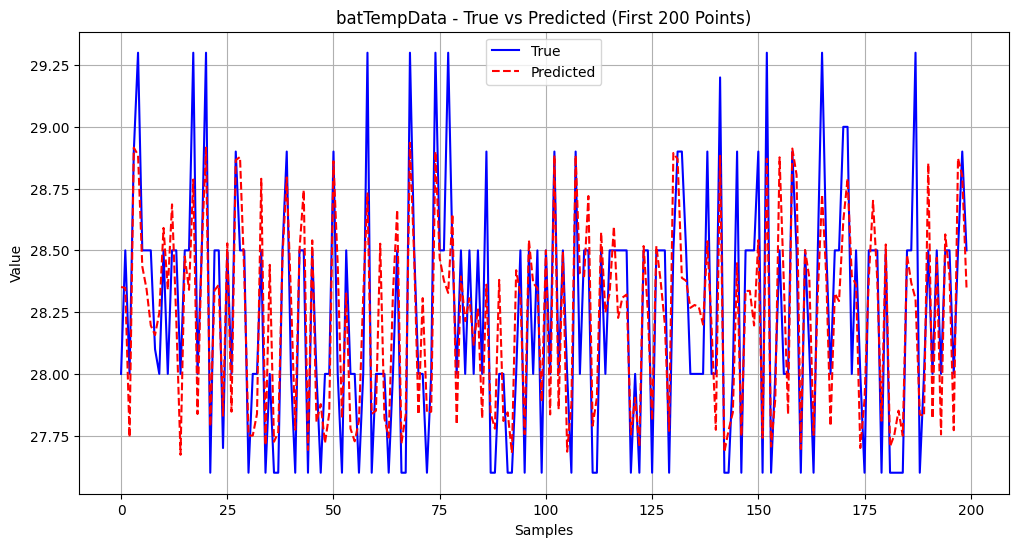

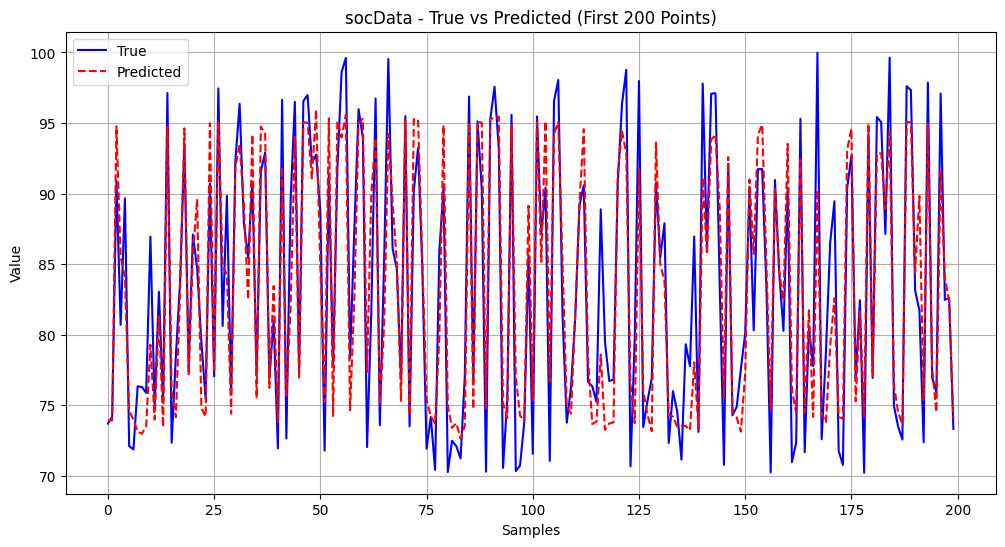

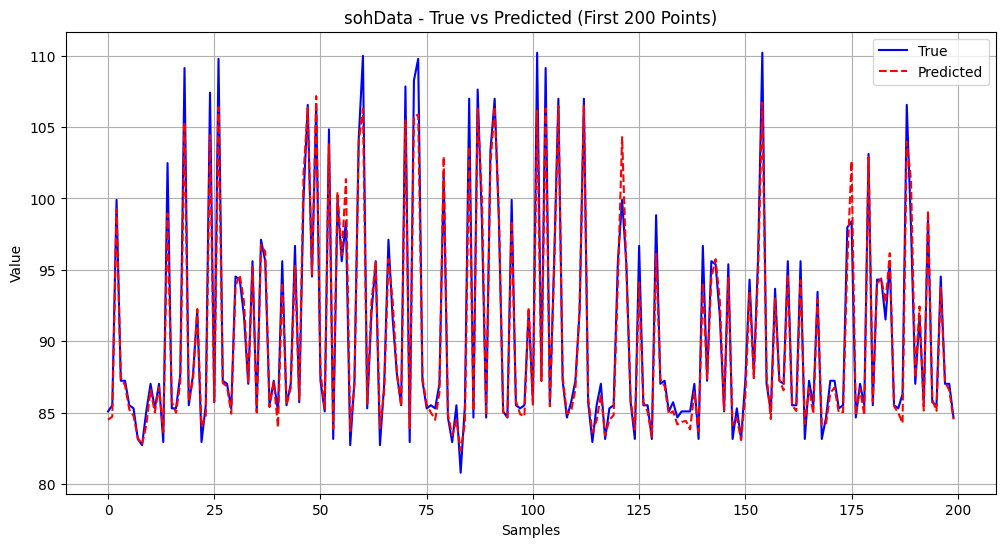

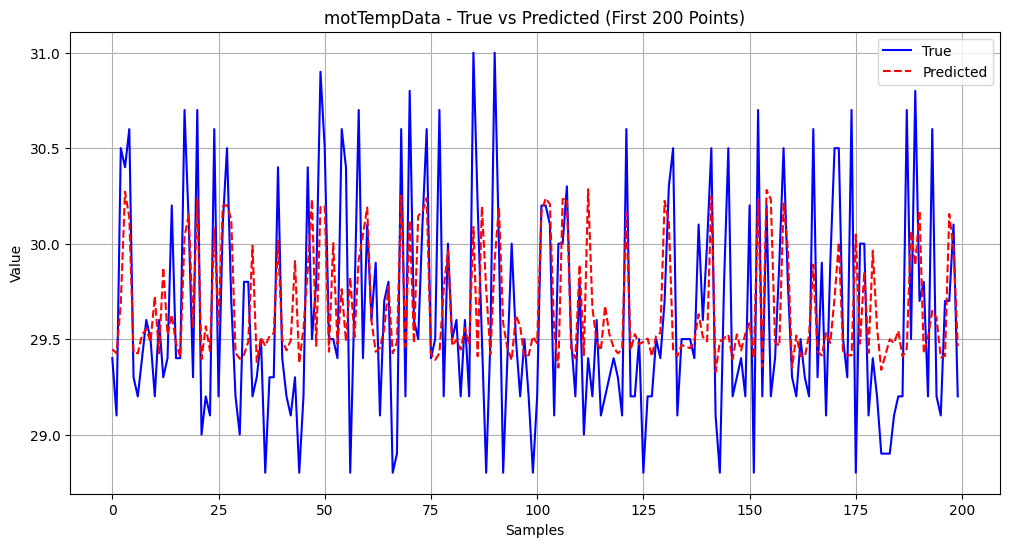

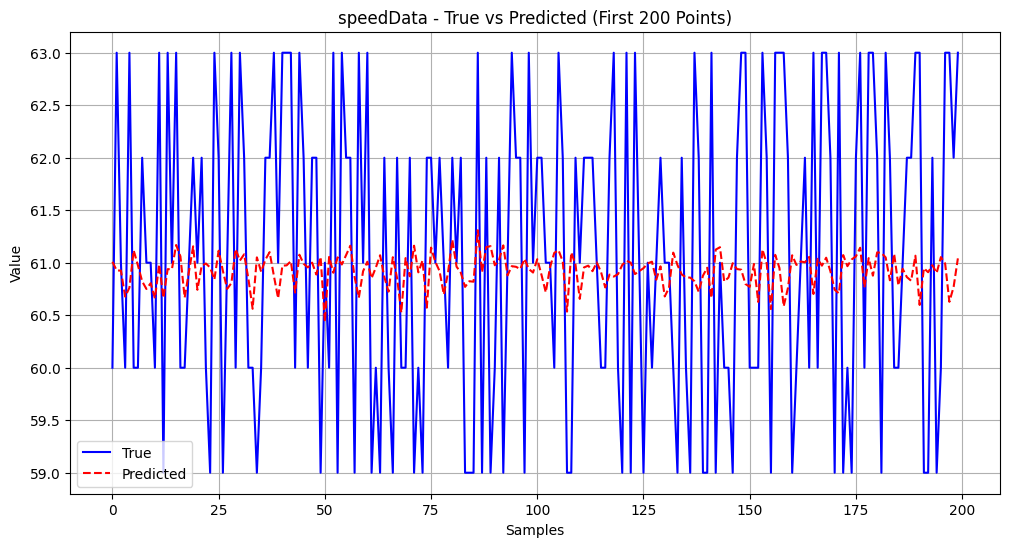

In [15]:
for i, feature in enumerate(output_features):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_rescaled[:200, i], 'b-', label='True')
    plt.plot(y_pred_rescaled[:200, i], 'r--', label='Predicted')
    plt.title(f'{feature} - True vs Predicted (First 200 Points)')
    plt.xlabel('Samples')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


In [16]:
model.save('LSTM_nn.h5')
model.save_weights('LSTM_model.weights.h5')

In [17]:
def predict_custom_input(custom_input):
    if len(custom_input) != scaler_x.n_features_in_:
        raise ValueError(f"Expected {scaler_x.n_features_in_} features, but got {len(custom_input)}.")
    custom_input_scaled = scaler_x.transform(np.array(custom_input).reshape(1, -1))

    if input_timesteps > 1:
        custom_input_scaled = np.repeat(custom_input_scaled, input_timesteps, axis=0)

    custom_input_scaled = custom_input_scaled.reshape((1, input_timesteps, custom_input_scaled.shape[1]))

    custom_pred_scaled = model.predict(custom_input_scaled)
    custom_pred = scaler_y.inverse_transform(custom_pred_scaled)
    return custom_pred

sample_input = [19998, 7.1258, 0.152423]
predicted_output = predict_custom_input(sample_input)
print("\nCustom Input Prediction:")
for i, feature in enumerate(output_features):
    print(f"{feature}: {predicted_output[0][i]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Custom Input Prediction:
batTempData: 27.7763
socData: 96.5742
sohData: 105.9308
motTempData: 30.0373
speedData: 61.1022


c:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [18]:
overall_mape = 100 - mean_absolute_percentage_error(y_test_rescaled.flatten(),y_pred_rescaled.flatten()) * 100

overall_r2 = r2_score(
    y_test_rescaled.flatten(),
    y_pred_rescaled.flatten()
)

print(f"\nOverall Model Performance:")
print(f"Overall Accuracy: {overall_mape:.2f}%")
print(f"Overall R² Score: {overall_r2:.4f}")


for i, feature in enumerate(output_features):
    feature_mape = 100 - mean_absolute_percentage_error(y_test_rescaled[:, i],y_pred_rescaled[:, i]) * 100
    print(f"\n{feature} Accuracy: {feature_mape:.2f}%")


Overall Model Performance:
Overall Accuracy: 98.31%
Overall R² Score: 0.9953

batTempData Accuracy: 99.25%

socData Accuracy: 96.49%

sohData Accuracy: 99.10%

motTempData Accuracy: 98.80%

speedData Accuracy: 97.92%
